In [45]:
# Importing libraries

import re
import pandas as pd
import numpy as np
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization, SimpleRNN,TimeDistributed
from tensorflow.keras import Sequential

#### Dataset Loading

In [2]:
# reading data

data = pd.read_csv(r'C:\Data Science\AI\NLP\Lecture Notebooks\googleplaystore_user_reviews.csv')

data.head()

,App,Translated_Review,Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive
2,10 Best Foods for You,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive
4,10 Best Foods for You,Best idea us,Positive


In [3]:
# drop unnecessary columns and rename cols

data.drop(['App'], axis=1, inplace=True)

data.columns = ['review', 'sentiment']

data.head()

,review,sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,Works great especially going grocery store,Positive
4,Best idea us,Positive


#### EDA

In [4]:
# check data shape

data.shape

(64295, 2)

In [5]:
# check missing values

data.isna().sum()

review       26868
sentiment    26863
dtype: int64

In [6]:
# dropping null values

data.dropna(inplace=True)

<Axes: xlabel='sentiment'>

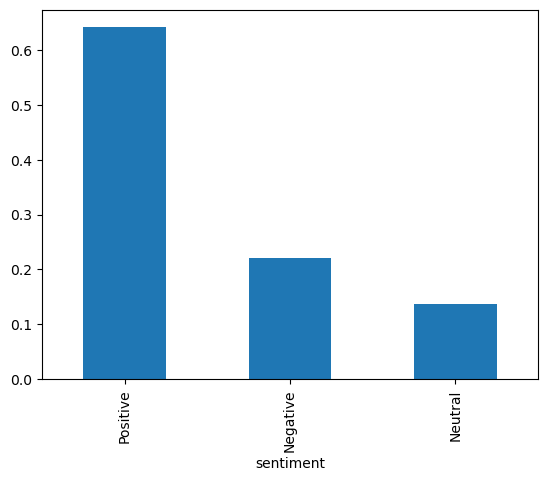

In [7]:
# check target balance

data['sentiment'].value_counts(normalize = True).plot.bar()

#### Text Preprocessing pipeline

In [8]:
# text preprocessing

def preprocess_pipeline(text_data):
    # create a list text

    lemmatizer = WordNetLemmatizer()

    if str(type(text_data)) != "<class 'str'>":
        text = list(text_data)
        
        # preprocessing loop

        corpus = []

        for i in range(len(text)):

            r = re.sub('[^a-zA-Z]', ' ', text[i])

            r = r.lower()

            r = r.split()

            # r = [word for word in r if word not in stopwords.words('english')]

            r = [lemmatizer.lemmatize(word) for word in r]

            r = ' '.join(r)

            corpus.append(r)

        return corpus
    
    else:
        
        r = re.sub('[^a-zA-Z]', ' ', text_data)

        r = r.lower()

        r = r.split()

        r = [word for word in r if word not in stopwords.words('english')]

        r = [lemmatizer.lemmatize(word) for word in r]

        r = ' '.join(r)

        return r

In [9]:
#assign corpus to data['text']
preprocessed_text = preprocess_pipeline(data['review'])

In [10]:
data['review'] = preprocessed_text

data.head()

,review,sentiment
0,i like eat delicious food that s i m cooking f...,Positive
1,this help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


In [11]:
# data.to_csv('sentiments_cleaned_data.csv', index=False)

In [12]:
data.head()

,review,sentiment
0,i like eat delicious food that s i m cooking f...,Positive
1,this help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


#### Train-Test split

In [13]:
# Create Feature and Label sets

X = data['review']

y = data['sentiment']


# train test split (66% train - 33% test)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print('Training Data :', X_train.shape)

print('Testing Data : ', X_test.shape)

Training Data : (26198,)
Testing Data :  (11229,)


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Feature Extraction

#### Using Embeddings in Keras library

In [15]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

15497

In [17]:
# Pad the sequences to a fixed length
max_length = 10
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [24]:
# Define the ANN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=5, input_length=max_length))
model.add(SimpleRNN(32,return_sequences=False, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 5)             77485     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 78,800
Trainable params: 78,800
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
655/655 [==============================] - 4s 4ms/step - loss: 0.8192 - accuracy: 0.6627 - val_loss: 0.6269 - val_accuracy: 0.7342
Epoch 2/10
655/655 [==============================] - 2s 3ms/step - loss: 0.5545 - accuracy: 0.7812 - val_loss: 0.5164 - val_accuracy: 0.7863
Epoch 3/10
655/655 [==============================] - 2s 3ms/step - loss: 0.4061 - accuracy: 0.8509 - val_loss: 0.5091 - val_accuracy: 0.8044
Epoch 4/10
655/655 [==============================] - 2s 3ms/step - loss: 0.3303 - accuracy: 0.8799 - val_loss: 0.5375 - val_accuracy: 0.8103
Epoch 5/10
655/655 [==============================] - 2s 3ms/step - loss: 0.2852 - accuracy: 0.8997 - val_loss: 0.5341 - val_accuracy: 0.8124
Epoch 6/10
655/655 [==============================] - 2s 4ms/step - loss: 0.2572 - accuracy: 0.9103 - val_loss: 0.5909 - val_accuracy: 0.8124
Epoch 7/10
655/655 [==============================] - 2s 4ms/step - loss: 0.2318 - accuracy: 0.9193 - val_loss: 0.6009 - val_accuracy: 0.8135
Epoch 

In [26]:
probabilities = model.predict(X_test)

probabilities

351/351 [==============================] - 1s 1ms/step


array([[1.84530485e-02, 1.18478825e-02, 9.69699085e-01],
       [7.66854942e-01, 1.63985908e-01, 6.91591427e-02],
       [1.97720006e-02, 3.94347793e-04, 9.79833663e-01],
       ...,
       [7.41418123e-01, 2.28057951e-01, 3.05239391e-02],
       [5.44115063e-03, 2.50970043e-04, 9.94307935e-01],
       [7.47102737e-01, 2.55845091e-03, 2.50338793e-01]], dtype=float32)

In [27]:
predictions = np.argmax(probabilities, axis=1)

predictions

array([2, 0, 2, ..., 0, 2, 0], dtype=int64)

In [28]:
# confusion matrix
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions),index=['Negative','Neutral','Positive'], columns=['Negative','Neutral','Positive'])

df

,Negative,Neutral,Positive
Negative,1496,141,844
Neutral,118,1101,329
Positive,408,255,6537


In [29]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.81
Recall: 0.81
